# Hall strip

**Background**

Motion in a rotating frame can be decomposed into a fast 'cyclotron' coordinate motion and a slower motion of the centers (X,Y) of cyclotron motion. It can be shown that X and Y do not commute, even though absolute spatial coordinates commute. As a result, a force generates motion in a perpendicular direction (the Hall effect). As a special case, a saddle potential enacts a squeezing operator on (X, Y), resulting in the exponential growth and decay of orthogonal sizes of a collection of particles. Since a BEC rotating sufficiently fast in an elliptical trap experiences a saddle potential in the rotating frame, this results in the extension of the cloud into a long strip. The strip has an unbounded length and a minimum width defined by the zero-point cyclotron motion of the bosons.

For more, see https://arxiv.org/abs/1911.12347


In [1]:
import sys, os
sys.path.append(os.path.abspath('..'))

import numpy as np
import matplotlib.pyplot as plt
from copy import copy, deepcopy
from tqdm.notebook import tqdm
from scipy.ndimage import rotate as rotate_image
from scipy.optimize import curve_fit
import time
import h5py
import pandas as pd
from PIL import Image
from condensate import Wavefunction, Environment, hbar
%matplotlib inline

## Prepare groundstate

In [778]:
omega   = 2*np.pi*10
epsilon = 0.225
dt = 1e-5
fov = 300e-6

e = Environment(DIM=512, fov=fov, N=0.5e6)
e.harmonic_potential(omega=omega, epsilon=epsilon)


            Running condensate on 512x512 grid with:
            atom number: 5e+05 
            mass:        3.80e-26
        


In [779]:
groundstate = Wavefunction(e)
groundstate.initialize_Psi(width=100)
groundstate.relax(vmax=3e8, dt=dt, steps=10000)

In [780]:
groundstate.env.rotating_frame(omegaR=[0.001]*10000)
groundstate.evolve(dt=dt, steps=10000, cooling=0.1)

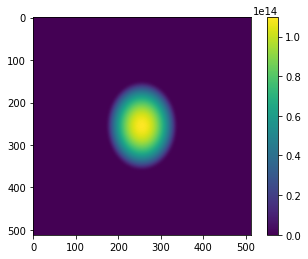

In [485]:
groundstate.show_density()

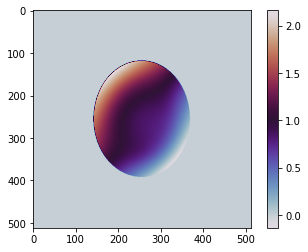

In [486]:
groundstate.show_phase()

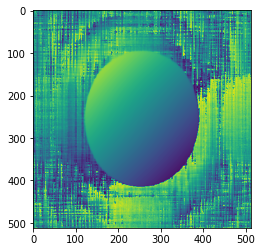

In [456]:
plt.imshow(np.angle(groundstate.Psi))

## Spin up

In [781]:
def rotation_freq_simple(timestep, whirrTime=30000, whirrMax=omega):
    tanh =  omega * 1.002 * np.tanh(3.46 * timestep / whirrTime)
    return np.min([whirrMax,tanh])

In [782]:
def rotation_freq(timestep, whirrTime=30000, whirrMax=omega):
    firstrampTime = whirrTime/10
    tanh1 =  np.max([0.05*omega, omega * 1.001 * np.tanh(3.3 * (timestep-0.86*firstrampTime) / whirrTime)])
    tanh2 =  0.05*omega *(0.97+ 1.001 * np.tanh(3.3 * (-firstrampTime+timestep) / firstrampTime))
    if timestep<firstrampTime:
        return tanh2
    else:
        return np.min([whirrMax,tanh1])
        

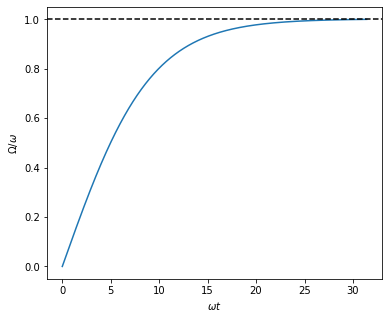

In [783]:
whirrMax = omega
steps = 50000
whirrtime = 50000
times = np.arange(steps)
Omega = [rotation_freq_simple(t, whirrTime=whirrtime) for t in times]

plt.figure(figsize=(6,5))
plt.plot(omega*dt*times, np.array(Omega)/omega)
plt.axhline(Omega[-1]/omega,ls='--',c='k')
plt.xlabel(r'$\omega t$')
plt.ylabel(r'$\Omega/\omega$')
plt.savefig('figures/rampup.png')
plt.show()

In [784]:
hallstrip = deepcopy(groundstate)

In [785]:
hallenv = hallstrip.env
hallenv.rotating_frame(omegaR=Omega)
hallenv.absorbing_boundaries(strength=100, radius=e.fov/2)

hallstrip.evolve(dt=dt, steps=steps, cooling=0.001)

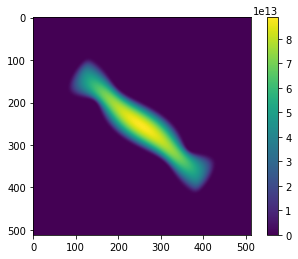

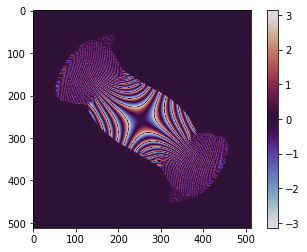

In [786]:
hallstrip.show_density()
hallstrip.show_phase()

In [787]:
widestrip = deepcopy(hallstrip)
# widestrip.env.g *= 1.17

In [788]:
def geometric_squeezing(stripPsi, steps=60000, frames=300, datafile='data/geometricsqueezing.hdf5'):
    steps = frames*(steps//frames)
    runtime = steps//frames
    times = np.arange(steps)
    Omega = omega* np.ones(runtime)
    dt = 1e-5
    psi = copy(stripPsi)
    psi.env.rotating_frame(omegaR=Omega)
    out = []
    density = psi.density
    density *= density>1
    out.append(density)
    
    for i in tqdm(range(frames), leave=False):
        psi.evolve(dt=dt, steps=runtime, cooling=0.0)
        density = psi.density
        density *= density>1
        out.append(density)
        
    with h5py.File(datafile, 'a') as f:
        dsname = f"geosqueeze"
        dset = f.create_dataset(dsname, data=np.array(out))
        dset.attrs['time'] = dt*runtime * np.arange(frames)
        dset.attrs['dt'] = dt

In [789]:
geometric_squeezing(widestrip, steps=90000, frames=300)

## Process Data

In [14]:
# Set some processing parameters
viewx = 350
viewy = 350
fov = 300e-6
dx = fov/512
mass = 3.8e-26
lb = np.sqrt(hbar / (2*mass *omega))
x  = dx * (np.arange(viewx) - viewx//2)
y  = dx * (np.arange(viewy) - viewy//2)
dt = 1e-5
times = np.arange(51)*dt*5e3


def gauss(x,x0,a,s): return a*np.exp(- (x-x0) **2 / (2*s**2))

def satexp(t, tau,a): return (3.31+a*np.exp(-t/tau))

def rotate_crop(array, viewx=200, viewy=350, angle=0):
    """ Rotate and crop a 2d array """
    s = np.shape(array)
    rotated = rotate_image(array, angle, reshape=False)
    cropped = rotated[(s[0]-viewy)//2 : (s[0]+viewy)//2 , (s[1]-viewx)//2 : (s[1]+viewx)//2 ]
    return cropped

def find_angle(ncrop):
    xsize = len(ncrop)
    xx = np.linspace(-10, 10, xsize)
    yy = np.linspace(-10, 10, xsize)
    xx, yy = np.meshgrid(xx, yy)

    # Calculate the moment of inertia tensor
    Ixx = np.sum(ncrop*yy*yy)
    Iyy = np.sum(ncrop*xx*xx)
    Ixy = np.sum(ncrop*xx*yy)
    Iyx = Ixy
    I =np.array( [[Ixx, Ixy], [Iyx, Iyy]])
    evals, evecs = np.linalg.eig(I)
    iangle = (180*np.arctan(evecs[np.argmin(evals)][1]/evecs[np.argmin(evals)][0])/np.pi)
    return iangle

    
def process_r1d(dset):
    """ Process a dataset corresponding to a single squeeze time """
    clouds = np.array([rotate_crop(a, viewx, viewy, 42) for a in dset[()]])
    times = np.array(dset.attrs['time'])
    xprofile  =  np.sum(rotate_crop(clouds[0],viewy=150), axis=0)
    xprofilemax = np.max(xprofile)
    gaussfit,_ = curve_fit(gauss, x, xprofile, [0, xprofilemax, 6e-6])
    newresults = pd.DataFrame([[clouds, times, xprofile, gaussfit]],
                              columns=columns)
    return newresults




In [1310]:
columns = ['cloud', 'time', 'xprofile', 'yprofile', 'gaussfit']
gs = pd.DataFrame(columns=columns)

with h5py.File('data/geometricsqueezing_withramp_straight.hdf5', 'r') as f:
    for name in tqdm(f):
        dset=f[name]
        alltimes =  np.array(dset.attrs['time'])
        for i in tqdm(range(len(dset)-1), leave=False):
            cloud = rotate_crop(np.fliplr(dset[i]), viewx, viewy, 43.5)
            xprofile  =  np.sum(rotate_crop(cloud, viewx=350, viewy=150), axis=0)
            xprofilemax = np.max(xprofile)
            gaussfit,_ = curve_fit(gauss, x, xprofile, [0, xprofilemax, 6e-6])
            yprofile = np.sum(rotate_crop(cloud, viewx=150, viewy=350), axis=1)
            newresults = pd.DataFrame([[cloud, alltimes[i], xprofile, yprofile, gaussfit]], columns=columns)
            gs = gs.append(newresults)
            
        
gs = gs.reset_index()        
    

### Hall drift velocity

In [1191]:
yprofiles = []
for i,r in gs.iterrows():
    if i>150:
        yprofiles.append(r.yprofile)
yprofiles = np.array(yprofiles)

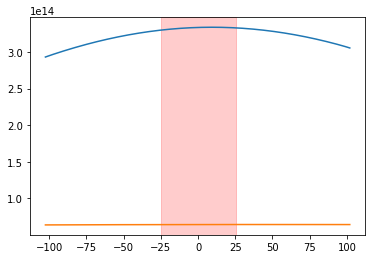

In [1192]:
R = 25e-6
mask = abs(y) < R
Rj = np.argmax(np.diff(mask))
plt.plot(1e6*y, yprofiles[0,:])
plt.plot(1e6*y, yprofiles[70,:])
plt.axvspan(-1e6*y[Rj],1e6*y[Rj], color='r', alpha=0.2)

In [1193]:
def linear(x,m,b): return m*x + b


Rs = np.linspace(5e-6,100e-6,100)
columns = ['R', 'xint', 'yint', 'fit', 'slope']
drift = pd.DataFrame(columns=columns)
deltat = (gs.iloc[1].time - gs.iloc[0].time)

for R in tqdm(Rs, leave=False):
    mask = abs(y) < R
    Rindex = np.argmax(np.diff(mask))
    N0 = np.sum(yprofiles[0,mask])
    xint = []
    yint = []
    for i,yp in enumerate(yprofiles):
        Nt = np.sum(yp[mask])
        integral = np.trapz(yprofiles[:i,Rindex] / dx, dx=deltat) 
        xint.append( 2*omega * lb * integral / N0)
        yint.append(1-(Nt/N0))
    f,_ = curve_fit(linear, xint,yint, [0.1,0])
        
    newresults = pd.DataFrame([[R, xint, yint, f, f[0]]], columns=columns)
    drift = drift.append(newresults)
    

In [1195]:
Forcestraight = 0.5*epsilon*driftstraight.R/lb
Forcequartic = 0.5*epsilon*driftquartic.R/lb

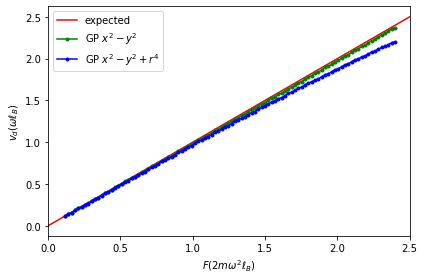

In [1226]:
testx = np.linspace(0,2.5)
plt.plot(testx, linear(testx,1,0),'r-', label='expected')
plt.plot(Forcestraight, driftstraight.slope,'g.-', label=r'GP $x^2-y^2$')
plt.plot(Forcequartic, driftquartic.slope,'b.-', label=r'GP $x^2-y^2 + r^4$')
plt.legend()
plt.xlabel(r'$F(2m\omega^2\ell_B)$')
plt.ylabel(r'$v_d (\omega\ell_B)$')
plt.xlim([0,2.5])
plt.tight_layout()
plt.savefig('figures/rotini1d/Fig2.png', dpi=120)

In [1224]:
gpexport = pd.DataFrame(columns=['F', 'saddle','quartic'])
gpexport.F = Forcestraight
gpexport.saddle = driftstraight.slope
gpexport.quartic = driftquartic.slope
gpexport.to_csv('data/gp_drift.csv')

In [1185]:
# driftquartic = drift.copy()

In [1194]:
# driftstraight = drift.copy()

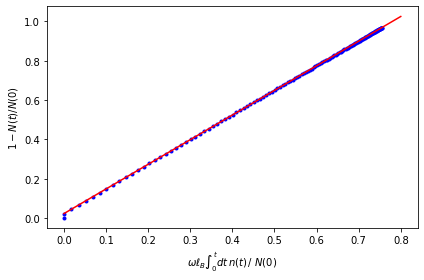

In [1225]:
plt.plot(drift.iloc[50].xint,drift.iloc[50].yint,'b.')
testx = np.linspace(0,0.8,100)
plt.plot(testx, linear(testx, *drift.iloc[50].fit),'r-')
plt.ylabel(r'$1-N(t)/N(0)$')
plt.xlabel(r'$\omega\ell_B\int_0^t dt \,n(t)\,/\,\,N(0)$')
plt.tight_layout()
plt.savefig('figures/rotini1d/Fig2inset.png', dpi=120)

### squeezing

In [1311]:
cloud = gs.iloc[202].cloud

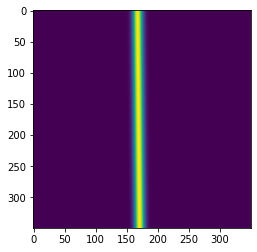

In [1312]:
plt.imshow(cloud)

In [1314]:
len(gs)

299

In [1321]:
gs.iloc[i].gaussfit

array([-3.61708912e-06,  1.05416298e+15,  3.50111465e-06])

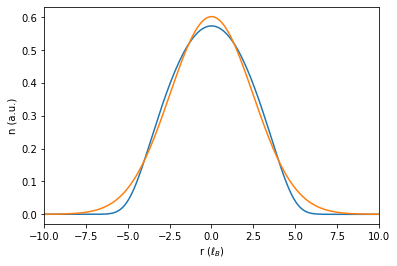

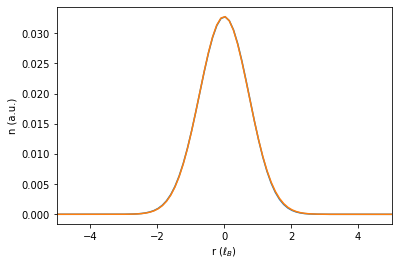

In [1345]:
i=2
plotx = (x-gs.iloc[i].gaussfit[0])/lb
plt.plot(plotx, 1e-16 * gs.iloc[i].xprofile)
plt.plot(plotx, 1e-16 * gauss(x,*gs.iloc[i].gaussfit))
plt.xlim([-10,10])
plt.xlabel(r'r ($\ell_B$)')
plt.ylabel(r'n (a.u.)')
plt.savefig('figures/rotini1d/largemu.png', dpi=120)
plt.show()
# i=50
# plotx = (x-gs.iloc[i].gaussfit[0])/lb
# plt.plot(plotx, 1e-16 * gs.iloc[i].xprofile)
# plt.plot(plotx, 1e-16 * gauss(x,*gs.iloc[i].gaussfit))
# plt.xlim([-5,5])
# plt.xlabel(r'r ($\ell_B$)')
# plt.ylabel(r'n (a.u.)')
# plt.show()
i=250
plotx = (x-gs.iloc[i].gaussfit[0])/lb
plt.plot(plotx, 1e-16 * gs.iloc[i].xprofile)
plt.plot(plotx, 1e-16 * gauss(x,*gs.iloc[i].gaussfit))
plt.xlim([-5,5])
plt.xlabel(r'r ($\ell_B$)')
plt.ylabel(r'n (a.u.)')
plt.savefig('figures/rotini1d/smallmu.png', dpi=120)

In [1347]:
i=250
gpexport = pd.DataFrame(columns=['x', 'n'])
gpexport.x, gpexport.n = (x-gs.iloc[i].gaussfit[0])/lb, 1e-16 * gs.iloc[i].xprofile
gpexport.to_csv('data/gp_smallmu.csv')

In [953]:
gs.head()

,index,cloud,time,xprofile,yprofile,gaussfit
0,0,"[[1.401598328629053e-91, -6.522537207706436e-9...",0.00000,"[5.003900388167875e-67, -1.7183211657713745e-6...","[6.404326397906974e-67, -2.3665977589346672e-6...","[-2.938353495336121e-07, 5991738607480485.0, 1..."
1,0,"[[1.295496093465275e-91, -6.045592157225509e-9...",0.00333,"[9.091133018019629e-67, -4.0443332694913383e-6...","[8.270803440189208e-67, -2.554360961718757e-66...","[-2.922051923759661e-07, 6002525941545424.0, 1..."
2,0,"[[1.0458469985499216e-91, -5.205801444324865e-...",0.00666,"[6.243376683084137e-67, -2.5869215348982634e-6...","[-1.7964573995511723e-66, 3.4367198879152513e-...","[-3.024224576360091e-07, 6023197151752448.0, 1..."
3,0,"[[-8.21898643415593e-90, 3.777976893138146e-89...",0.00999,"[1.936118223018931e-64, -7.484976675717121e-64...","[-7.722019649842711e-63, 2.7653541010978054e-6...","[-3.249178333952636e-07, 6052050045378970.0, 1..."
4,0,"[[5.737939168830828e-87, -2.5712980969526784e-...",0.01332,"[3.093553162586617e-63, -1.2528880502136718e-6...","[-2.1413644223372323e-60, 8.781601826536712e-6...","[-3.5819363857741725e-07, 6086239709737851.0, ..."


Text(0, 0.5, '$\\sigma$ [$\\mu m$]')

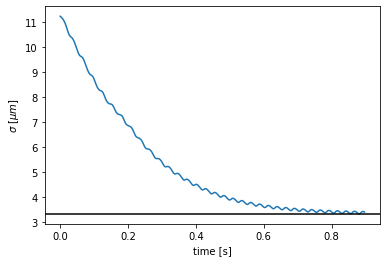

In [796]:
widths = np.array([abs(r[6][2]) for r in gs.itertuples()])
plt.plot(gs['time'], 1e6*widths)
plt.axhline(1e6*lb/np.sqrt(2),c='k')
plt.xlabel('time [s]')
plt.ylabel(r'$\sigma$ [$\mu m$]')
# plt.ylim([2,8.5])
# plt.savefig('figures/rotini1d/widths_nog.png')


In [797]:
labdata = pd.read_csv('data/widthData.csv', names=['zt', 's'])
labdata.sort_values(by='zt', inplace=True, ignore_index=True)

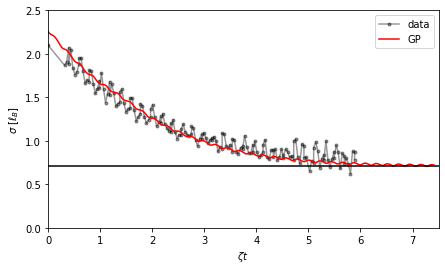

In [707]:
zeta = 1.2*epsilon * omega / 2
plt.figure(figsize=(7,4))
# plt.figure(figsize=(17,14))
widths = np.array([1e-6 * abs(r[6][2]) / lb for r in gs.itertuples()])
plt.plot(labdata.zt[labdata.s<3], labdata.s[labdata.s<3],'k.-' ,alpha=0.4, label='data')
plt.plot((zeta * gs['time'] )-0.2, 1e6*widths, 'r-', label='GP')
plt.axhline(1/np.sqrt(2),c='k')
plt.xlabel(r'$\zeta t$')
plt.ylabel(r'$\sigma$ [$\ell_B$]')
plt.legend()
plt.ylim([0,2.5])
plt.xlim([0,7.5])
# plt.savefig('figures/rotini1d/widths_much_less_wiggles.png', dpi=200)

In [708]:
gpexport = pd.DataFrame(columns=['zt', 's'])
gpexport.zt = (zeta * gs['time'] )-0.2
gpexport.s = 1e6*widths

In [709]:
# gpexport.to_csv('data/gp_squeezing_slowramp.csv')

Text(0, 0.5, '$\\sigma$ [$\\mu m$]')

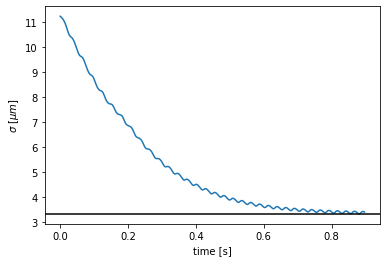

In [711]:
widths = np.array([abs(r[6][2]) for r in gs.itertuples()])
plt.plot(gs['time'], 1e6*widths)
plt.axhline(1e6*lb/np.sqrt(2),c='k')
plt.xlabel('time [s]')
plt.ylabel(r'$\sigma$ [$\mu m$]')
# plt.savefig('figures/rotini1d/widths.png')


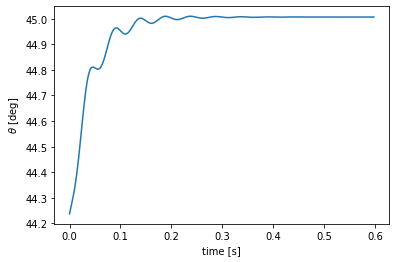

In [60]:
angles = []
for i,r in gs.iterrows():
    angles.append(find_angle(r.cloud))
    
plt.plot(gs['time'], -44.97+np.array(angles))
# plt.axhline(90,c='k')
plt.xlabel('time [s]')
plt.ylabel(r'$\theta$ [deg]')
# plt.savefig('figures/rotini1d/angles.png')

# Reproducing lab parameters


            Running condensate on 512x512 grid with:
            atom number: 8e+05 
            mass:        3.80e-26
        


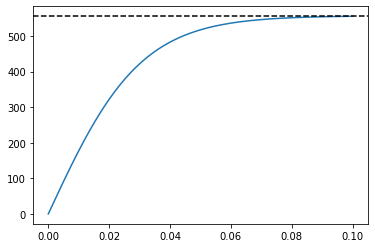

In [2]:
omega   = 2*np.pi*88.6
epsilon = 0.2
dt = 1e-6

e = Environment(DIM=512, fov=120e-6, N=8e5)
e.harmonic_potential(omega=omega, epsilon=epsilon)

groundstate = Wavefunction(e)
groundstate.initialize_Psi(width=100)
groundstate.relax(vmax=1e9, dt=2*dt, steps=4000)
groundstate.evolve(dt=dt, cooling=0.01, steps=4000)

whirrMax = omega
steps = 100000
whirrtime = 100000
times = np.arange(steps)
Omega = [np.min([whirrMax, omega * 1.001 * np.tanh(3.3 * t / whirrtime)]) for t in times]
plt.plot(dt*times, Omega)
plt.axhline(Omega[-1],ls='--',c='k')
plt.show()


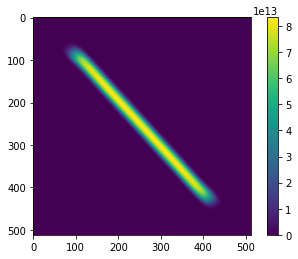

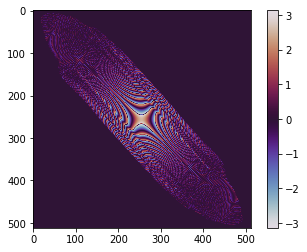

In [3]:
# Run the sim - takes longer than the 10Hz sim above
hallstrip = deepcopy(groundstate)
hallenv = hallstrip.env
hallenv.rotating_frame(omegaR=Omega)
hallenv.absorbing_boundaries(strength=1, radius=e.fov/2)

hallstrip.evolve(dt=dt, steps=steps, cooling=0)
hallstrip.show_density()
hallstrip.show_phase()

In [4]:
finalstrip = deepcopy(hallstrip)

## Crop and find the angle to the diagonal after the ramp

In [10]:
width = 512//2
plotrange=140
ncrop = finalstrip.density[(width-plotrange):(width+plotrange),(width-plotrange):(width+plotrange)]

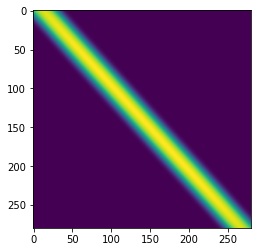

In [13]:
plt.imshow(ncrop)

In [20]:
xsize = len(ncrop)
xx = np.linspace(-10, 10, xsize)
yy = np.linspace(-10, 10, xsize)
xx, yy = np.meshgrid(xx, yy)

# Calculate the moment of inertia tensor
Ixx = np.sum(ncrop*yy*yy)
Iyy = np.sum(ncrop*xx*xx)
Ixy = np.sum(ncrop*xx*yy)
Iyx = Ixy
I =np.array( [[Ixx, Ixy], [Iyx, Iyy]])
evals, evecs = np.linalg.eig(I)
iangle = (180*np.arctan(evecs[np.argmin(evals)][1]/evecs[np.argmin(evals)][0])/np.pi)


In [21]:
print(f"angle from diagonal equipotential: {(iangle-45):.2f} degrees")

angle from diagonal equipotential: 2.47 degrees


## Quartic potential


            Running condensate on 512x512 grid with:
            atom number: 1e+05 
            mass:        3.80e-26
        


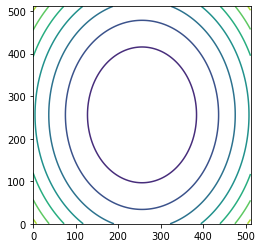

In [7]:
omega   = 2*np.pi*10
epsilon = 0.225
dt = 1e-5
fov = 300e-6
DIM = 512

e = Environment(DIM=512, fov=fov, N=1e5)
V = np.zeros((DIM,DIM))
for i in range(DIM):
    for j in range(DIM):
        x = (i-DIM//2)*fov / DIM
        y = (j-DIM//2)*fov / DIM
        rsq = x**2 + y**2
        harmonic = 0.5 * e.mass * ( ((1-epsilon) * (omega * x) **2) + 
                                    ((1+epsilon) * (omega * y) **2))
        quartic =  3e6* 0.5 * e.mass * (omega**2) * (rsq**2)
        V[i,j] = (harmonic +  quartic)/hbar
e.custom_potential(V)
e.show_potential()

In [1237]:
groundstate = Wavefunction(e)
groundstate.initialize_Psi(width=100)
groundstate.relax(vmax=3e8, dt=dt, steps=4000)

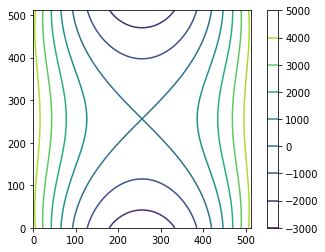

In [1238]:
V = e.V.copy()
for i in range(DIM):
    for j in range(DIM):
        x = (i-DIM//2)*fov / DIM
        y = (j-DIM//2)*fov / DIM
        rsq = x**2 + y**2
        centrif = 0.5 * e.mass * (omega**2) * rsq
        V[i,j] -= centrif/hbar
a = plt.contour(V)
plt.colorbar()
plt.gca().set_aspect('equal', 'box')
plt.show()

In [8]:
def rotation_freq(timestep, whirrTime=30000, whirrMax=omega):
    return np.min([whirrMax, omega * 1.001 * np.tanh(3.3 * timestep / whirrTime)])

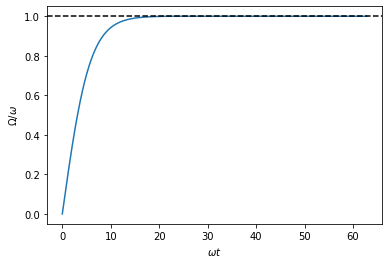

In [9]:
steps = 100000
times = np.arange(steps)
Omega = [ rotation_freq(t) for t in times]

plt.plot(omega*dt*times, np.array(Omega)/omega)
plt.axhline(Omega[-1]/omega,ls='--',c='k')
plt.xlabel(r'$\omega t$')
plt.ylabel(r'$\Omega/\omega$')
# plt.savefig('figures/rampup.png')
plt.show()

In [1245]:
def geometric_squeezing_withramp(stripPsi, steps=60000, frames=300, datafile='data/geometricsqueezing_withramp.hdf5'):
    steps = frames*(steps//frames)
    runtime = steps//frames
    dt = 1e-5
    out = []
    psi = copy(stripPsi)
    
    for i in tqdm(range(frames), leave=False):
        
        times = np.arange(i*runtime, (i+1)*runtime)
        psi.env.rotating_frame(omegaR=[ rotation_freq(t) for t in times ])
        psi.evolve(dt=dt, steps=runtime, cooling=0.0)
        density = psi.density
        density *= density>1
        out.append(density)
        
    with h5py.File(datafile, 'a') as f:
        dsname = f"geosqueeze"
        dset = f.create_dataset(dsname, data=np.array(out))
        dset.attrs['time'] = dt*runtime * np.arange(frames)
        dset.attrs['dt'] = dt

In [1246]:
hallstrip = deepcopy(groundstate)
hallstrip.env.absorbing_boundaries(strength=1, radius=e.fov/2)

In [1163]:
geometric_squeezing_withramp(hallstrip, steps=60000, datafile='data/geometricsqueezing_withramp_quartic.hdf5')

In [2]:
columns = ['cloud', 'time']
gs = pd.DataFrame(columns=columns)

with h5py.File('data/geometricsqueezing_withramp_quartic.hdf5', 'r') as f:
    for name in tqdm(f):
        dset=f[name]
        alltimes =  np.array(dset.attrs['time'])
        for i in tqdm(range(len(dset)-1), leave=False):
            cloud = np.fliplr(dset[i])
            newresults = pd.DataFrame([[cloud, alltimes[i]]], columns=columns)
            gs = gs.append(newresults)
            
        
        
    

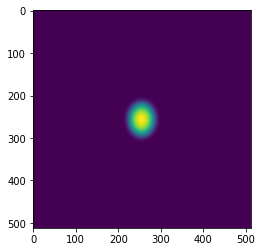

In [3]:
plt.imshow(gs.iloc[0].cloud)

In [10]:
steps = 60000
times = np.arange(steps)
Omega = [ rotation_freq(t) for t in times]
frames= 300

In [11]:
def plot_frame(frame, savefig=False):
    
    V_frame = hallstrip.env.V.copy()
    Omega_frame = Omega[frame*(steps//frames)]
    
    for i in range(DIM):
        for j in range(DIM):
            x = (i-DIM//2)*fov / DIM
            y = (j-DIM//2)*fov / DIM
            rsq = x**2 + y**2
            centrif = 0.5 * e.mass * (Omega_frame**2) * rsq
            V_frame[i,j] -= centrif/hbar
            
    f, axarr = plt.subplots(ncols=2, figsize=(8,4))
    axarr[0].imshow(gs.iloc[frame].cloud, vmax=5e13, extent=1e6*np.array([-fov/2,fov/2,-fov/2,fov/2]), cmap='inferno')
    axarr[0].contour(V_frame, 25, alpha=0.7,
                     vmin=-1e3, vmax=1e3, extent=1e6*np.array([-fov/2,fov/2,-fov/2,fov/2]), cmap='RdBu_r')
    axarr[0].set_aspect('equal', 'box')
    view = 213/2
    axarr[0].set(xlim=[-view,view], ylim=[-view,view], xlabel=r'x [$\mu m$]', ylabel=r'y [$\mu m$]')

    
    axarr[1].plot(omega*dt*times, np.array(Omega)/omega)
    plt.axhline(Omega[-1]/omega,ls='--',c='k')
    xnow = omega*dt*times[frame * steps//frames]
    ynow = Omega_frame/omega
    axarr[1].set(xlim=[0,np.max(omega*dt*times)], ylim=[0,1.1], xlabel=r'$\omega t$', ylabel=r'$\Omega/\omega$')
    axarr[1].plot([xnow], [ynow], 'ro')
    plt.axvline(xnow, c='k', alpha=0.1)
    plt.axhline(ynow, c='k', alpha=0.1)
    plt.tight_layout()
    if savefig:
        plt.savefig(f'figures/rotini1d/quartic_frames/geosqueeze_{frame}.jpg', dpi=190)
        plt.close()

In [12]:
plot_frame(140, savefig=False)

NameError: name 'hallstrip' is not defined

In [1300]:
2*1e-6*(213/2) * DIM / fov

363.52000000000004

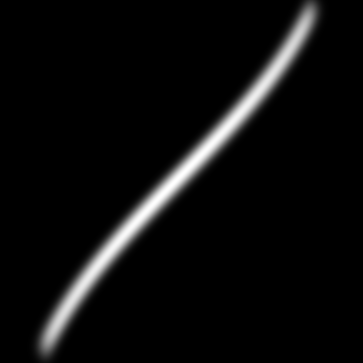

In [16]:
img = gs.iloc[140].cloud
img = np.uint8(255*img/np.max(img))
size=363
img = rotate_crop(img, viewx=size,viewy=size)
im = Image.fromarray(img)
im
# im.save('figures/rotini1d/GPquarticframe.tiff')

NameError: name 'buf' is not defined

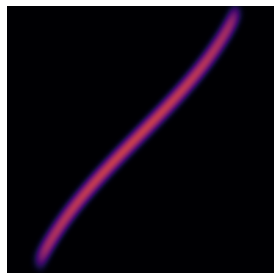

In [1281]:
plt.imshow(gs.iloc[140].cloud, vmax=5e13, extent=1e6*np.array([-fov/2,fov/2,-fov/2,fov/2]), cmap='inferno')


In [384]:
for frame in tqdm(range(frames-1)):
    plot_frame(frame, savefig=True)

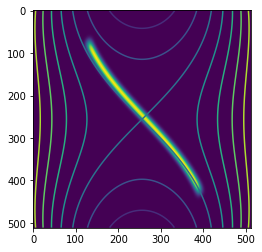

In [338]:
V = hallenv.V.copy()
for i in range(DIM):
    for j in range(DIM):
        x = (i-DIM//2)*fov / DIM
        y = (j-DIM//2)*fov / DIM
        rsq = x**2 + y**2
        centrif = 0.5 * e.mass * (omega**2) * rsq
        V[i,j] -= centrif/hbar
a = plt.contour(V)
plt.gca().set_aspect('equal', 'box')
plt.imshow(hallstrip.density)
plt.show()

In [84]:
hallenv.rotating_frame(omegaR = [omega]*40000)
hallstrip.evolve(dt=dt, steps=40000)

# Noninteracting

In [ ]:
omega   = 2*np.pi*10
epsilon = 0.225
dt = 1e-5
fov = 300e-6

e = Environment(DIM=512, fov=fov, N=0.00001)
e.harmonic_potential(omega=omega, epsilon=epsilon)

groundstate = Wavefunction(e)
groundstate.initialize_Psi(width=100)
groundstate.relax(vmax=3e8, dt=dt, steps=4000)

In [ ]:
hallstrip = deepcopy(groundstate)


In [ ]:

hallenv = hallstrip.env
hallenv.rotating_frame(omegaR=[omega]*100)
hallenv.absorbing_boundaries(strength=1, radius=e.fov/2)

hallstrip.evolve(dt=dt, steps=100, cooling=0)

In [ ]:
widestrip = deepcopy(hallstrip)

In [ ]:
geometric_squeezing(widestrip, steps=70000, frames=300, datafile='data/geometricsqueezing_nonint.hdf5')

In [ ]:
columns = ['cloud', 'time', 'xprofile', 'gaussfit']
gsnonint = pd.DataFrame(columns=columns)

with h5py.File('data/geometricsqueezing_nonint.hdf5', 'r') as f:
    for name in tqdm(f):
        dset=f[name]
        alltimes =  np.array(dset.attrs['time'])
        for i in tqdm(range(len(dset)-1), leave=False):
            cloud = rotate_crop(np.fliplr(dset[i]), viewx, viewy, 42.2)
            xprofile  =  np.sum(rotate_crop(cloud, viewx=350, viewy=150), axis=0)
            xprofilemax = np.max(xprofile)
            gaussfit,_ = curve_fit(gauss, x, xprofile, [0, xprofilemax, 6e-6])
            newresults = pd.DataFrame([[cloud, alltimes[i], xprofile, gaussfit]], columns=columns)
            gsnonint = gsnonint.append(newresults)
            
        

In [ ]:
widths = np.array([abs(r[4][2]) for r in gs.itertuples()])
plt.plot(gs['time'], 1e6*widths)
plt.axhline(1e6*lb/np.sqrt(2),c='k')
plt.xlabel('time [s]')
plt.ylabel(r'$\sigma$ [$\mu m$]')
plt.ylim([2,8.5])
# plt.savefig('figures/rotini1d/widths_nog.png')


In [ ]:
zeta = 0.222 * omega / 2
plt.figure(figsize=(7,4))
# plt.figure(figsize=(17,14))
widths = np.array([1e-6 * abs(r[4][2]) / lb for r in gs.itertuples()])
widthsnonint = np.array([1e-6 * abs(r[4][2]) / lb for r in gsnonint.itertuples()])
plt.plot(labdata.zt, labdata.s,'k.-' ,alpha=0.05, label='data')
plt.plot((zeta * gs['time'] )+1.54, 1e6*widths, 'r-', label='GP')
plt.plot((zeta * gsnonint['time'] )+3, 1e6*widthsnonint, 'b-', label='GP g=0')
plt.axhline(1/np.sqrt(2),c='k')
plt.xlabel(r'$\zeta t$')
plt.ylabel(r'$\sigma$ [$\ell_B$]')
plt.legend()
plt.ylim([0,2])
plt.xlim([0,8.5])
# plt.savefig('figures/rotini1d/widths_vsnonint.png', dpi=200)